In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
device = 0
np.random.seed(0)
torch.random.manual_seed(0)

## Difference from tensorflow implementation(so far)
1. Time step is not input to neural net
2. Initial state is initialized randomly and learnable, instead of zero

In [2]:
def generate_left_prob(held_out_range = [[0.1, 0.2], [0.3, 0.4]]):
    def check_heldout(left_prob):
        inrange = False
        for low, high in held_out_range:
            if left_prob>low and left_prob<high:
                inrange = True
        return inrange
    left_prob = -1
    while left_prob<0 or left_prob>0.5 or check_heldout(left_prob):
        left_prob = np.random.uniform(0, 0.5)
    return left_prob

def get_trial(current_state, left_prob, action): # get next trial after action
    assert 0<=left_prob and left_prob<=0.5, "probability out of range"
    right_prob = 0.5-left_prob
    current_state = current_state.copy()
    current_state[action] = 0
    if np.random.uniform()<left_prob:
        current_state[0] = 1
    if np.random.uniform()<right_prob:
        current_state[1] = 1
    return current_state

def discount(rewards, value_preds, discount_f):
    cumsum = value_preds[-1]
    value_targets = []
    for i in range(1, len(rewards)):
        index = -i-1 # starting at -2, ending at 0
        cumsum = cumsum*discount_f+rewards[index]
        value_targets = [cumsum]+value_targets
    return value_targets

In [3]:
minimum = 30
for i in range(10000):
    minimum = min(minimum, np.random.uniform())

In [4]:
class A3C(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.init_h = torch.nn.Parameter(torch.zeros(1, 48)).cuda(device)
        self.init_c = torch.nn.Parameter(torch.zeros(1, 48)).cuda(device)
        self.lstm = torch.nn.LSTMCell(3, 48)
        self.action_head = torch.nn.Linear(48, 2)
        self.value_head = torch.nn.Linear(48, 1)
    def forward(self, prev_action, prev_reward, lstm_state):
        input_vec = torch.zeros(3).cuda(device)
        if prev_action!=-1: # if not first trial
            input_vec[prev_action] = 1
        input_vec[2] = prev_reward
        if lstm_state == None:
            h, c = self.lstm(input_vec[None, ...], (self.init_h, self.init_c))
        else:
            h, c = self.lstm(input_vec[None, ...], lstm_state)
        action_probs = self.action_head(h).softmax(1).clamp(min = 1e-8)
        value = self.value_head(h)
        return action_probs, value, (h, c)

agent = A3C().cuda(device)
optimizer = torch.optim.RMSprop(agent.parameters(), 0.007)

In [5]:
# actions = [a0, a1, a2, ...., aT]
# value_preds = [V0, V1, V2, ...., VT]
# rewards = [r0, r1, r2, ..... , rT]
# value_target = []
def run_block(block_num, train = True, bv = 0.05, be = 0.05, discount_f = 0.75):
    num_trials = np.random.randint(50, 101)
    left_prob = generate_left_prob()
    state = get_trial([0, 0], left_prob, 0)
    action = -1
    reward = 0.25
    lstm_state = None
    value_preds = []
    rewards = []
    actions = []
    policies = []
    for trial_num in range(num_trials):
        action_probs, value_pred, lstm_state = agent(action, reward, lstm_state)
        action = np.random.choice([0, 1], p = action_probs.detach().cpu().numpy().flatten())
        reward = state[action]
        policies.append(action_probs[0])
        value_preds.append(value_pred)
        actions.append(action)
        rewards.append(reward)
        state = get_trial(state, left_prob, action)
    if train:
        optimizer.zero_grad()
        value_targets = torch.Tensor(discount(rewards, value_preds, discount_f)).cuda(device)
        value_preds = torch.Tensor(value_preds[:-1]).cuda(device)
        policies = torch.stack(policies[:-1], dim = 0)
        actions = torch.Tensor(actions[:-1]).long()
        advantage = (value_targets - value_preds).detach()
        value_loss = torch.nn.MSELoss()(value_preds, value_targets)
        policy_loss = -torch.mean(torch.log(policies[torch.arange(policies.shape[0]), actions])*advantage)
        entropy_loss = -torch.mean(torch.log(policies)*policies)
        loss = policy_loss + value_loss*bv + entropy_loss*be
        loss.backward()
        optimizer.step()
    print('trial block:', block_num, 'reward:', sum(rewards)/num_trials)
    left_ratio = sum(actions).item()/actions.shape[0]
    return left_ratio, left_prob

In [6]:
left_ratios = []
left_probs = []
for block_num in range(1000):
    left_ratio, left_prob = run_block(block_num)
    left_ratios.append(left_ratio)
    left_probs.append(left_prob)


trial block: 0 reward: 0.34615384615384615
trial block: 1 reward: 0.2125
trial block: 2 reward: 0.3918918918918919
trial block: 3 reward: 0.25510204081632654
trial block: 4 reward: 0.014925373134328358
trial block: 5 reward: 0.05405405405405406
trial block: 6 reward: 0.5283018867924528
trial block: 7 reward: 0.10638297872340426
trial block: 8 reward: 0.19148936170212766
trial block: 9 reward: 0.01694915254237288
trial block: 10 reward: 0.4805194805194805
trial block: 11 reward: 0.27692307692307694
trial block: 12 reward: 0.07865168539325842
trial block: 13 reward: 0.4342105263157895
trial block: 14 reward: 0.5882352941176471
trial block: 15 reward: 0.07352941176470588
trial block: 16 reward: 0.2727272727272727
trial block: 17 reward: 0.19444444444444445
trial block: 18 reward: 0.2289156626506024
trial block: 19 reward: 0.05660377358490566
trial block: 20 reward: 0.42528735632183906
trial block: 21 reward: 0.010526315789473684
trial block: 22 reward: 0.1388888888888889
trial block: 23 r

trial block: 198 reward: 0.5416666666666666
trial block: 199 reward: 0.36619718309859156
trial block: 200 reward: 0.5054945054945055
trial block: 201 reward: 0.3473684210526316
trial block: 202 reward: 0.03225806451612903
trial block: 203 reward: 0.3392857142857143
trial block: 204 reward: 0.07352941176470588
trial block: 205 reward: 0.1506849315068493
trial block: 206 reward: 0.4888888888888889
trial block: 207 reward: 0.5409836065573771
trial block: 208 reward: 0.46511627906976744
trial block: 209 reward: 0.2413793103448276
trial block: 210 reward: 0.1
trial block: 211 reward: 0.4864864864864865
trial block: 212 reward: 0.02857142857142857
trial block: 213 reward: 0.5405405405405406
trial block: 214 reward: 0.20754716981132076
trial block: 215 reward: 0.13636363636363635
trial block: 216 reward: 0.34545454545454546
trial block: 217 reward: 0.08974358974358974
trial block: 218 reward: 0.47959183673469385
trial block: 219 reward: 0.36538461538461536
trial block: 220 reward: 0.476190476

trial block: 391 reward: 0.06153846153846154
trial block: 392 reward: 0.2549019607843137
trial block: 393 reward: 0.0
trial block: 394 reward: 0.1896551724137931
trial block: 395 reward: 0.32
trial block: 396 reward: 0.16304347826086957
trial block: 397 reward: 0.3269230769230769
trial block: 398 reward: 0.20430107526881722
trial block: 399 reward: 0.4246575342465753
trial block: 400 reward: 0.4074074074074074
trial block: 401 reward: 0.047619047619047616
trial block: 402 reward: 0.1978021978021978
trial block: 403 reward: 0.20833333333333334
trial block: 404 reward: 0.4
trial block: 405 reward: 0.39080459770114945
trial block: 406 reward: 0.5
trial block: 407 reward: 0.10294117647058823
trial block: 408 reward: 0.24742268041237114
trial block: 409 reward: 0.5454545454545454
trial block: 410 reward: 0.04477611940298507
trial block: 411 reward: 0.0
trial block: 412 reward: 0.46153846153846156
trial block: 413 reward: 0.3924050632911392
trial block: 414 reward: 0.0
trial block: 415 rewar

trial block: 588 reward: 0.5076923076923077
trial block: 589 reward: 0.023255813953488372
trial block: 590 reward: 0.5376344086021505
trial block: 591 reward: 0.47761194029850745
trial block: 592 reward: 0.03333333333333333
trial block: 593 reward: 0.11538461538461539
trial block: 594 reward: 0.041666666666666664
trial block: 595 reward: 0.25
trial block: 596 reward: 0.24
trial block: 597 reward: 0.42857142857142855
trial block: 598 reward: 0.04477611940298507
trial block: 599 reward: 0.4857142857142857
trial block: 600 reward: 0.38181818181818183
trial block: 601 reward: 0.3972602739726027
trial block: 602 reward: 0.07
trial block: 603 reward: 0.532608695652174
trial block: 604 reward: 0.1590909090909091
trial block: 605 reward: 0.5087719298245614
trial block: 606 reward: 0.25252525252525254
trial block: 607 reward: 0.30357142857142855
trial block: 608 reward: 0.05333333333333334
trial block: 609 reward: 0.2597402597402597
trial block: 610 reward: 0.45652173913043476
trial block: 611 

KeyboardInterrupt: 

/home/joseph/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


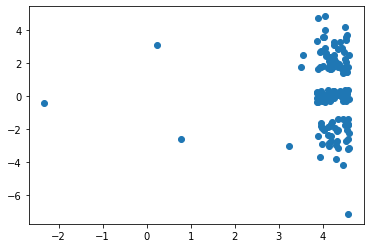

In [7]:
left_ratios, left_probs = np.array(left_ratios), np.array(left_probs)
action_ratio = np.log(left_ratios/(1-left_ratios))
prob_ratio = np.log(left_probs/(0.5-left_probs))
plt.plot(action_ratio, prob_ratio, marker='o', linestyle="None")

In [8]:
print(left_ratios)

[0.55844156 0.08860759 0.68493151 0.97938144 0.98484848 1.
 1.         1.         1.         0.98275862 0.98684211 0.984375
 1.         0.98666667 1.         1.         1.         0.98591549
 1.         0.98076923 1.         0.9893617  1.         1.
 1.         1.         1.         1.         0.98989899 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.98529412 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.98823529 1.
 1.         1.         1.         1.         1.         1.
 0.98701299 1.         1.         1.         1.         1.
 1.         1.         1.         1.      